In [2]:
# automatically update imports
%load_ext autoreload
%autoreload 2

# snippet for relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [27]:
import extract_uses.main

extract_uses.main.main()

('Folder already exists. Assumption: Already processed, then ignoring...', 'grenoble/')


In [15]:
import loaders
import extract_uses.utils as utils

city_ref = 'grenoble'
activities_shp = city_ref+"/full_activities.shp"
residential_shp = city_ref+"/full_residential.shp"

bbox = utils.getBoundingBox(activities_shp)
print(bbox)

geo_graph = loaders.load_graph(city_ref, bbox)
pois_df = loaders.load_extracted_osm_pois(activities_shp)
pois_residential_df = loaders.load_extracted_osm_pois(residential_shp)
centrality_df = loaders.load_centrality(city_ref, geo_graph)
kde_df = loaders.load_kde(city_ref, geo_graph, pois_df)
kde_residential_df = loaders.load_kde(city_ref, geo_graph, pois_residential_df)

('Bounding box:', [45.11334367251151, 5.5764359, 45.24389538600425, 5.9025706])
[45.11334367251151, 5.5764359, 45.24389538600425, 5.9025706]
Querying locally for `['nodes', 'edges']`
`['nodes', 'edges']` is/are not stored locally. Determining it/them through `graph_from_bbox` method
Saving data for `['nodes', 'edges']` at `/home/lgervasoni/urbansprawl/urban_analysis/hdfs_store/grenoble.h5`
The data has been stored locally with success
Querying locally for `['centrality']`
`['centrality']` is/are not stored locally. Determining it/them through `get_centrality_df` method
Saving data for `['centrality']` at `/home/lgervasoni/urbansprawl/urban_analysis/hdfs_store/grenoble.h5`
The data has been stored locally with success
Querying locally for `['kde']`
`['kde']` is/are not stored locally. Determining it/them through `get_kde_df` method
Saving data for `['kde']` at `/home/lgervasoni/urbansprawl/urban_analysis/hdfs_store/grenoble.h5`
The data has been stored locally with success
Querying loca

In [16]:
pois_residential_df.head()

,key,lat,lon,value
id,,,,
3125851694,residential,45.175168,5.685236,2.01242498918
3125871835,residential,45.176450,5.685244,2.01242498918
3125845858,residential,45.175347,5.685257,2.01242498918
3125875838,residential,45.176648,5.685276,2.01242498918
3125843734,residential,45.175531,5.685284,2.01242498918


In [17]:
pois_df.head()

,key,lat,lon,value
id,,,,
1920271581,shop,45.125433,5.576436,interior_decoration
1920271584,shop,45.125623,5.576625,supermarket
2174187162,shop,45.130817,5.581009,cheese
871753987,shop,45.130947,5.581115,convenience
2174186970,shop,45.127480,5.589134,sports


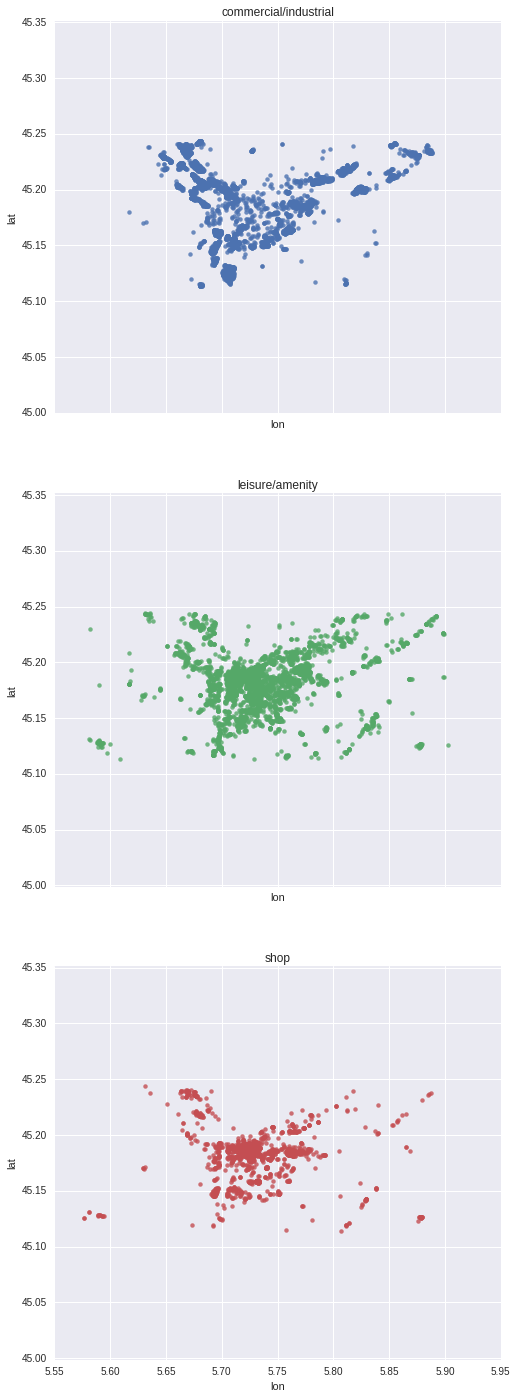

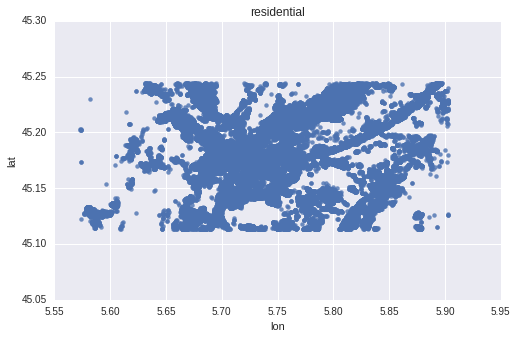

In [18]:
import plots

%matplotlib inline
plots.pois_scatter(pois_df)
plots.pois_scatter(pois_residential_df)

In [19]:
kde_df.head()

,commercial/industrial,leisure/amenity,shop
501809164,-1.844177,-1.843166,-1.842946
501809165,-1.844332,-1.843312,-1.843105
501809166,-1.844465,-1.843441,-1.843243
501809167,-1.844141,-1.843124,-1.842906
501809168,-1.844334,-1.843313,-1.843107


In [20]:
import pandas as pd

# TODO: automatize this in some module

centrality_kde_df = pd.concat([
    pd.DataFrame({ key: value for (key, value) in zip(kde_df.columns, list(map(kde_df.__getitem__, kde_df.columns))) }),
    centrality_df], axis=1, keys=['kde', 'centrality'])
centrality_kde_df.head()

kde                            centrality            \
       commercial/industrial leisure/amenity      shop betweenness closeness   
124550             -1.840324       -1.839397 -1.838643    0.000000  0.012469   
124551             -1.840299       -1.839374 -1.838625    0.000049  0.012499   
124552             -1.840299       -1.839361 -1.838624    0.002273  0.012557   
124553             -1.840322       -1.839381 -1.838641    0.000460  0.012752   
124554             -1.840565       -1.839619 -1.838837    0.002527  0.013692   

                  
          degree  
124550  0.000192  
124551  0.000287  
124552  0.000287  
124553  0.000287  
124554  0.000287

In [21]:
# TODO: automatize this in some module
centrality_kde_corr = centrality_kde_df.corr().xs('kde', level=0).xs('centrality', level=0, axis=1)
centrality_kde_corr

,betweenness,closeness,degree
commercial/industrial,0.134645,0.593440,0.170853
leisure/amenity,0.136153,0.585835,0.169272
shop,0.132883,0.594954,0.172314


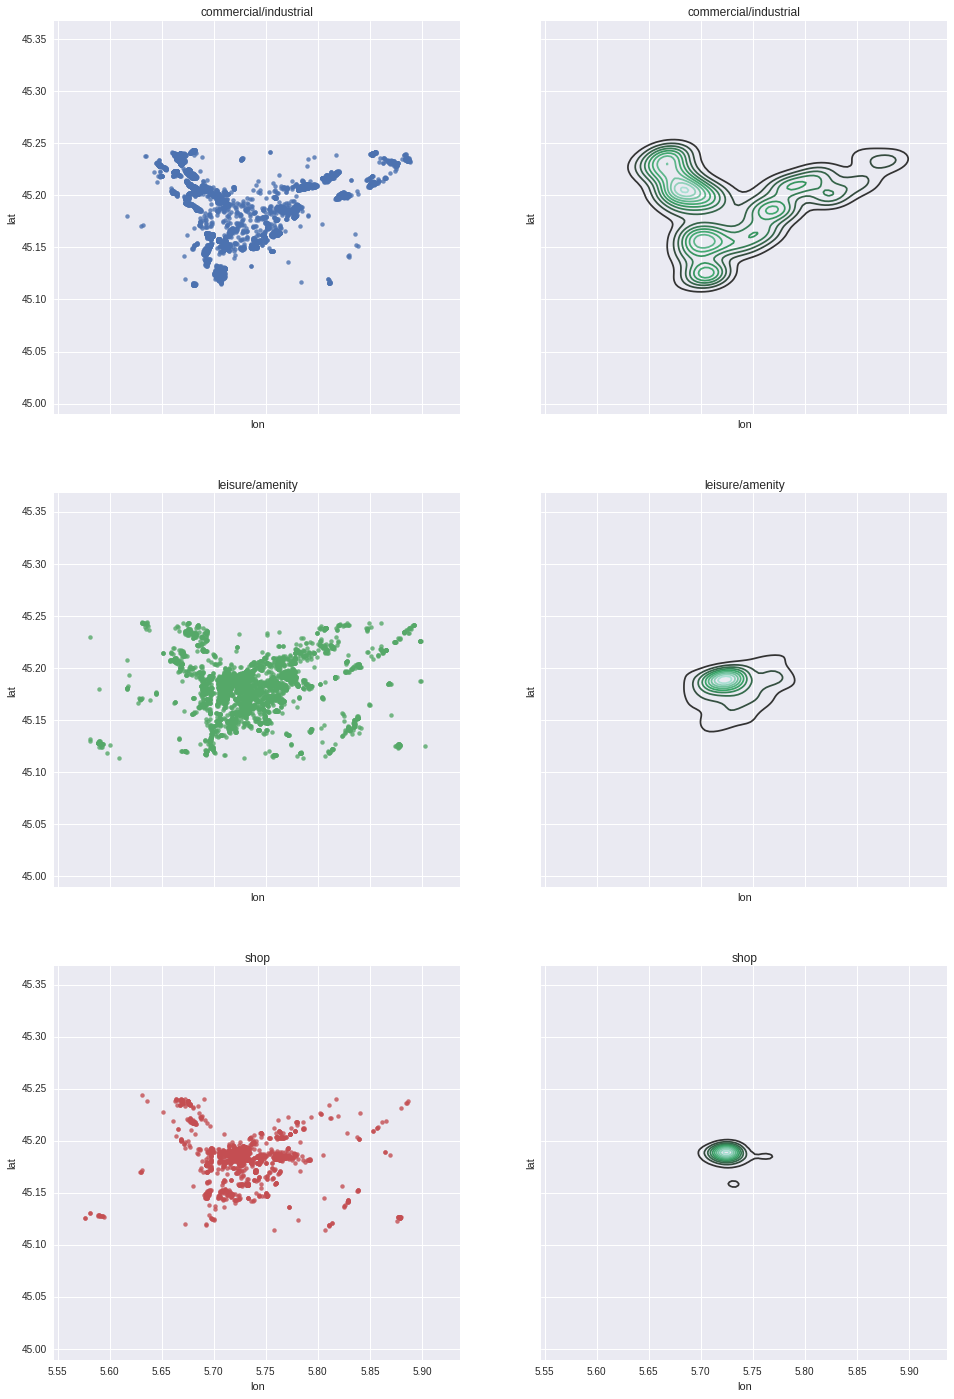

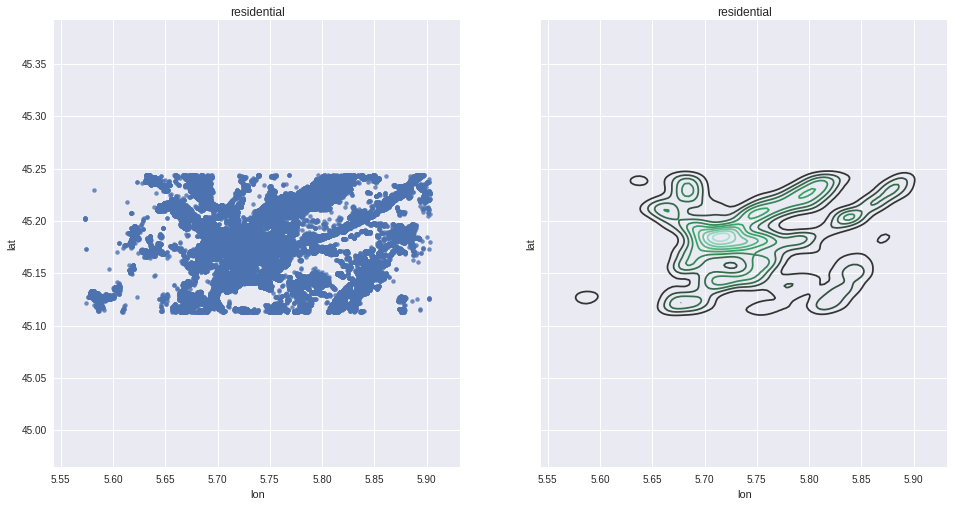

In [22]:
plots.pois_scatter_kde(pois_df, kde_df)
plots.pois_scatter_kde(pois_residential_df, kde_residential_df)

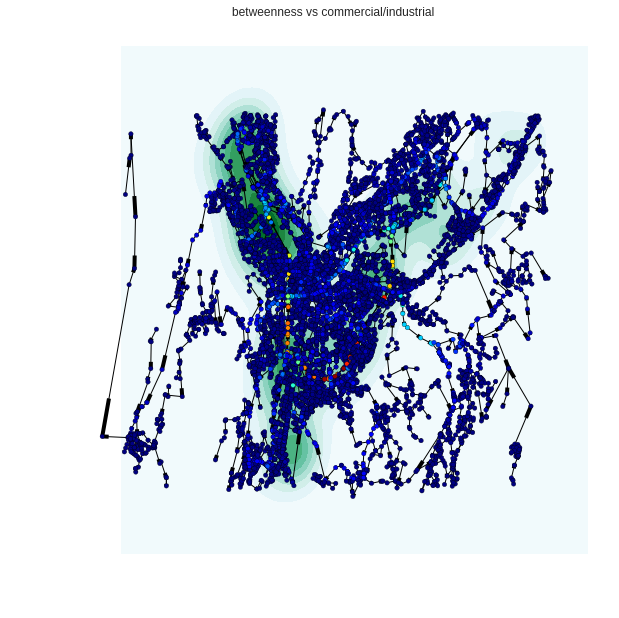

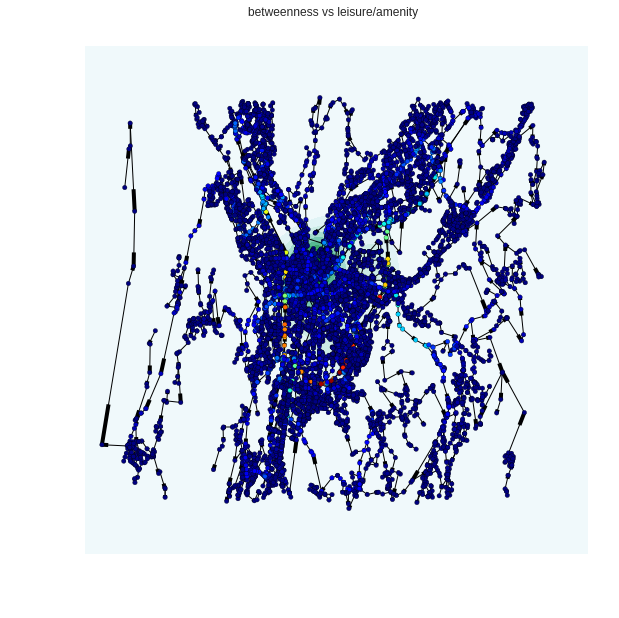

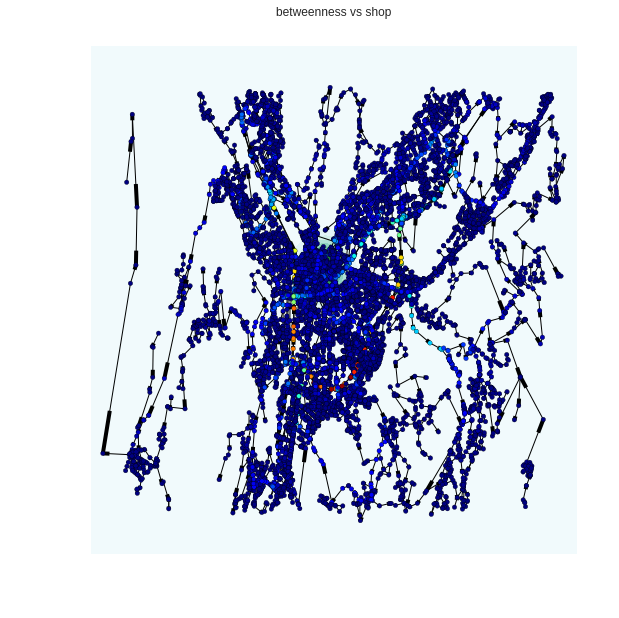

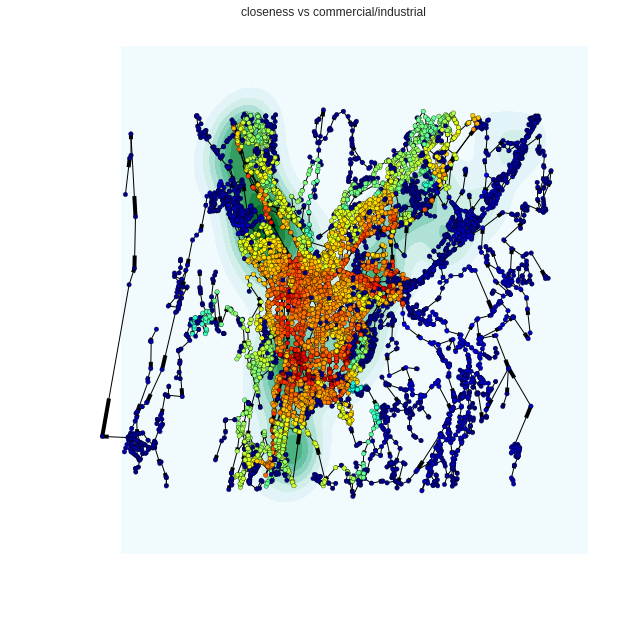

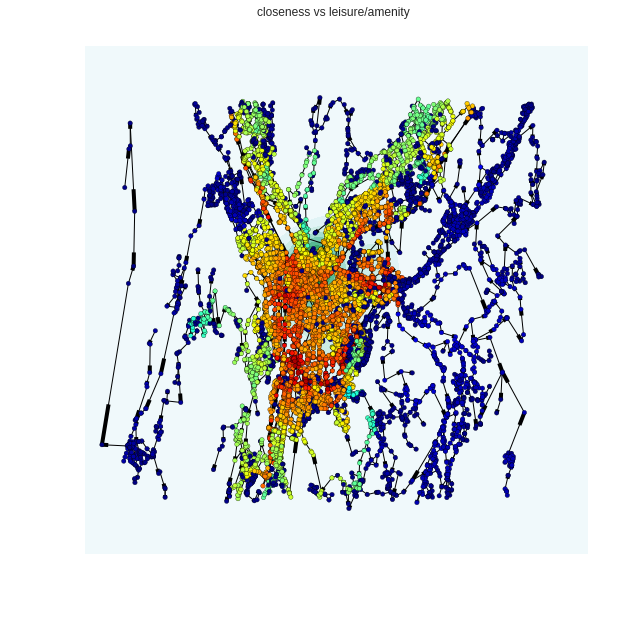

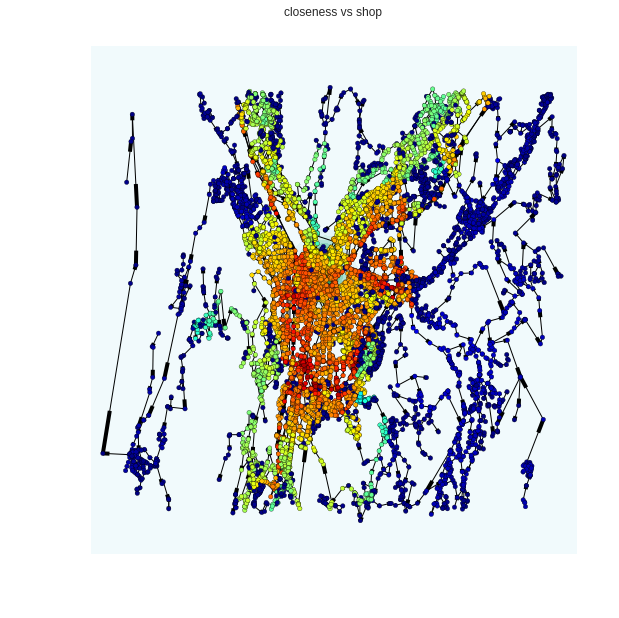

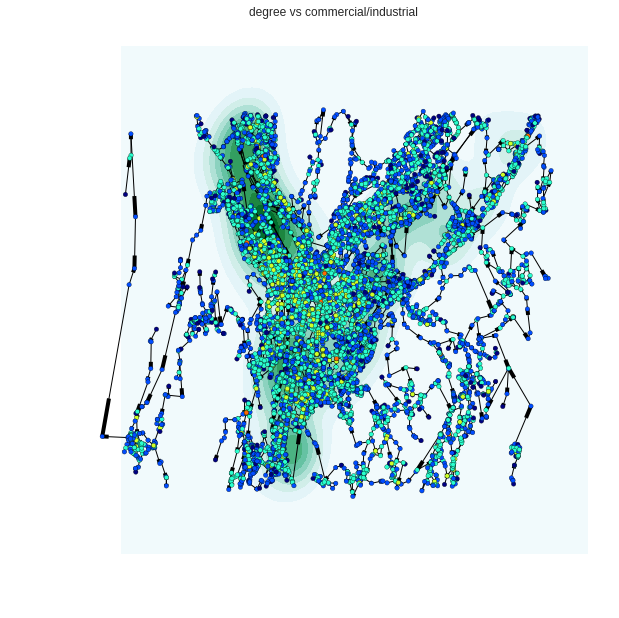

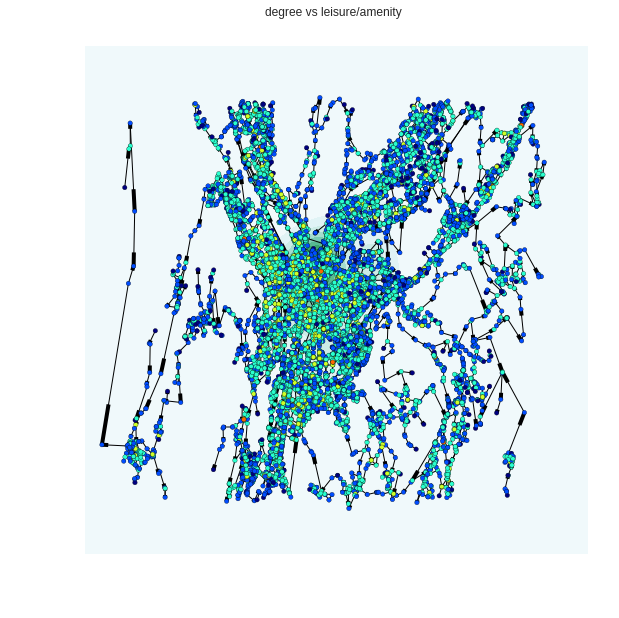

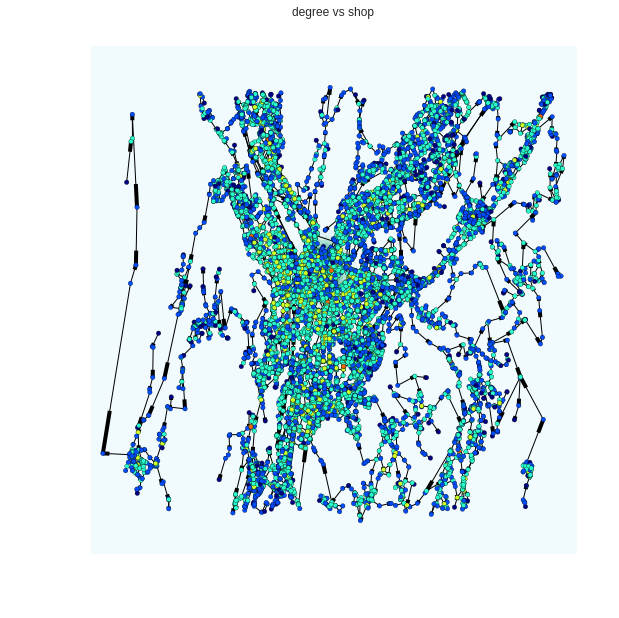

In [24]:
# TODO: create method for this in plots.py
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib qt
%matplotlib inline

cmap = plt.get_cmap('jet')

for centrality_label in centrality_df:
    for category_label, category_ser in pois_df.groupby(by=['key']):
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_title(centrality_label + ' vs ' + category_label)
        sns.kdeplot(category_ser['lon'], category_ser['lat'], ax=ax, legend=True, shade=True)
        geo_graph.plot(ax, node_color = [centrality_df[centrality_label][node.id] for node in geo_graph], node_size=20, cmap=cmap) # TODO: maybe hide edges